In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")

In [3]:
df = pd.read_csv('../logs/training_2018-09-22 12:25:23.132954.log', delimiter=',')
df.head()

,epoch,acc,loss,val_acc,val_loss
0,0,0.018836,0.706315,0.062280,0.356821
1,1,0.162055,0.206955,0.134023,0.189939
2,2,0.372193,0.167090,0.146855,0.185131
3,3,0.419597,0.156696,0.125792,0.168646
4,4,0.182126,0.169581,0.147974,0.165309


# Visualize Loss

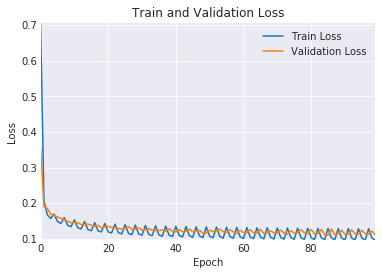

In [6]:
ax = plt.gca()
ax.set_xmargin(0)
ax.set_ymargin(0)
plt.plot(df['epoch'], df['loss'], label="Train Loss")
plt.plot(df['epoch'], df['val_loss'], label="Validation Loss")
plt.legend()
plt.title('Train and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# Visualize Accuracy

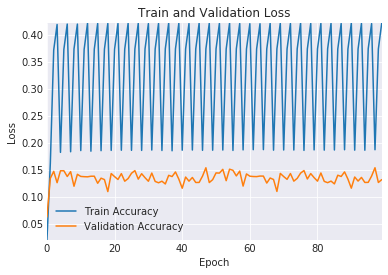

In [7]:
ax = plt.gca()
ax.set_xmargin(0)
ax.set_ymargin(0)
plt.plot(df['epoch'], df['acc'], label="Train Accuracy")
plt.plot(df['epoch'], df['val_acc'], label="Validation Accuracy")
plt.legend()
plt.title('Train and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# Visualize Final Result

In [41]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pyexr
import matplotlib.pyplot as plt
import os

TESTDATA_DIR = '/media/marcelsantos/DATA/Marcel/DeepShading/DeepShadingTestImages'
VALIDATIONDATA_DIR = '/media/marcelsantos/DATA/Marcel/DeepShading/DeepShadingValidationImages'
FILE_NAME = '0000000004.exr'
OUTPUT_NAME = 'Sibenik' + FILE_NAME

json_file = open('../models/model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = keras.models.model_from_json(loaded_model_json)

# Load weights into new model.
loaded_model.load_weights('../models/model_2018-09-22 12:25:23.132954.h5')
print("[INFO] Loaded model from disk")
 
# Compile the model.
loaded_model.compile(optimizer=tf.train.AdamOptimizer(0.0001),
              loss='mean_absolute_error',
              metrics=['accuracy'])

# Evaluate loaded model on test data.
normal_image = pyexr.read_all(VALIDATIONDATA_DIR + '/Sibenik/Normals/' + FILE_NAME)['default'][:,:,0:3]
position_image = pyexr.read_all(VALIDATIONDATA_DIR + '/Sibenik/Position/'+ FILE_NAME)['default'][:,:,0:3]
input_image = np.dstack([normal_image, position_image])

batch = np.expand_dims(input_image, axis=0)

print('[INFO] Batch Shape', batch.shape)
data = loaded_model.predict(batch, 1)[0]
result = data[:,:,0] 

print('[INFO] Data Shape', data.shape)

[INFO] Loaded model from disk
[INFO] Batch Shape (1, 512, 512, 6)
[INFO] Data Shape (512, 512, 1)


# Save the predicted image

[INFO] Save image (512, 512, 1)


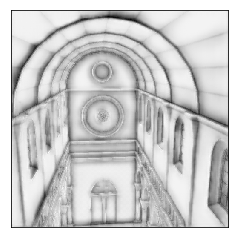

In [42]:
print('[INFO] Save image', data.shape)
plt.xticks([])
plt.yticks([])
plt.imshow(result, cmap='gray')
plt.show()

In [43]:
result = np.expand_dims(result, axis=2)
result = np.dstack([result, result, result, np.ones_like(result)])
pyexr.write(OUTPUT_NAME, result)
print('[INFO] Done!')

[INFO] Done! (512, 512, 1)
